In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/davcic/CP_Testing')
sys.path.append('/home/davcic/CP_Testing/HDPHMM')

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt
import generate_timeseries as gent2

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3, 4'
print(f'Selected CPU')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

# from jax.config import config
# config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
import gc

sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent

name = 'Toy_dataset_RBF_3'

Selected CPU


In [4]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from itertools import combinations, permutations
from matplotlib.lines import Line2D



def multicolored_line_collection(x, y, z, colors, lw=2):
    """ Color a 2D line based on which state it is in

    :param x: data x-axis values
    :param y: data y-axis values
    :param z: values that determine the color of each (x, y) pair
    """

    nstates = colors.shape[0]
    # come up with color map and normalization (i.e. boundaries of colors)

    cmap = ListedColormap(colors)
    bounds = np.arange(-1, nstates) + 0.1
    norm = BoundaryNorm(bounds, cmap.N)  # add

    # create line segments to color individually
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Set the values used for colormapping
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)
    lc.set_linewidth(lw)

    z2 = np.unique(z)

    def make_proxy(zvalue, scalar_mappable, **kwargs):
        color = scalar_mappable.cmap(scalar_mappable.norm(zvalue))
        return Line2D([0, 1], [0, 1], color=color, **kwargs)
    
    proxies = [make_proxy(item, lc, linewidth=2) for item in z2]
    

    return lc, proxies

def organize_states(true_states, true_state_labels, found_states, estimated_states):
    """ determine the optimal match between the estimated state sequence and the found state labels

    :param true_states:
    :param true_state_labels:
    :param found_states:
    :param estimated_states:
    :return:
    """

    # if too few states were found, add a dummy state in order to make following calculations work
    dummies = []
    if len(found_states) < len(true_state_labels):
        print('Less states were found than exist...adding a dummy state')
        for i in range(len(true_state_labels) - len(found_states)):
            #dummy = sum(found_states)  # add all the found states to get a unique dummy state label
            dummy = 0
            while dummy in found_states:
                dummy += 1
            found_states.append(dummy)
            dummies.append(dummy)

    # We need to identify which states match up with the known labels. I think the Munkres algorithm is a more
    # efficient way of doing this
    mismatches = []  # count up the number of mismatches for each subset and its permutations
    subsets = list(combinations(found_states, len(true_state_labels)))
    nperm = len(list(permutations(subsets[0])))
    for sub in subsets:
        p = permutations(sub)
        for i, perm in enumerate(p):
            M = dict(zip(true_state_labels, perm))
            wrong = 0
            for s, estimate in enumerate(estimated_states):
                if estimate != M[true_states[s]]:
                    wrong += 1
            mismatches.append(wrong)

    mindex = np.argmin(mismatches)  # index of minimum number of wrong label assignments
    subset = subsets[(mindex // nperm)]  # subset number of minimum wrong labels
    p = list(permutations(subset))  # permutations of subset
    states = list(p[mindex % nperm])  # the states listed in subset in the order that leads to minimum wrong labels

    return states

def summarize_results(ihmm, cmap=plt.cm.jet, traj_no=0, plot_dim='all', savename=None, shuffle=False,
                          crange=(50, 225)):
        """ Plot estimated state sequence. If true labels exist, compare those.
        """

        # Get data
        estimated_states = ihmm.z[traj_no, :]
        dim = ihmm.trajectories.shape[2]  # number of dimensions of trajectory
        shift = 1.5 * ihmm.trajectories[:, traj_no, :].max()

        found_states = list(np.unique(estimated_states))

        nT = len(estimated_states)

        state_counts = [list(estimated_states).count(s) for s in found_states]
        # print(state_counts)
        # print(estimated_states[:25])

        print('Found %d unique states' % len(found_states))

        if ihmm.labels is not None:

            true_states = ihmm.labels[ihmm.order:, traj_no]
            true_state_labels = list(np.unique(true_states))
            nstates = len(true_state_labels)
            print('%d states were used to generate this data' % nstates)
            states = organize_states(true_states, true_state_labels, found_states, estimated_states)

        else:
            states = found_states

        # Print estimate properties
        estimated_transition_matrix = ihmm.pi_z[tuple(np.meshgrid(states, states))].T

        # normalize so rows sum to 1
        for i in range(len(states)):
            estimated_transition_matrix[i, :] /= estimated_transition_matrix[i, :].sum()

        print(np.diagonal(estimated_transition_matrix))
        # print('\nEstimated Transition Matrix:\n')
        # print(estimated_transition_matrix)

        if ihmm.labels is not None:

            actual_transition_matrix = ihmm.actual_T
            # rms = np.sqrt(np.square(estimated_transition_matrix - actual_transition_matrix).mean())
            #
            # print('\nActual Transition Matrix:\n')
            # print(actual_transition_matrix)
            #
            # print('\nRoot mean squared error between estimated and true matrices: %.4f\n' % rms)

            # give extra states their own labels
            diff = len(found_states) - len(states)  # difference between no. of found states and actual no. of states
            extra_states = [x for x in found_states if x not in states]
            if diff > 0:
                for i in range(diff):
                    states.append(extra_states[i])
                    true_state_labels.append(nstates + i)

            M = dict(zip(true_state_labels, states))  # dictionary of state numbers mapped to original labels
            reverseM = dict(zip(states, true_state_labels))

            # determine the indices where the wrong label assignments occur
            wrong_label = []
            for s, estimate in enumerate(estimated_states):
                if estimate != M[true_states[s]]:
                    wrong_label.append(s)

            print('Correctly identified %.1f %% of states' % (100 * (1 - (len(wrong_label) / len(estimated_states)))))
        else:
            M = dict(zip(found_states, np.arange(len(found_states))))

        # MLE autoregressive coefficients and covariance matrices
        # print(ihmm.theta['A'][..., states[2], 0])
        # print(np.linalg.inv(ihmm.theta['invSigma'][..., states[2], 0]))

        # Make a color-coded plot

        # randomly assign color values from colormap

        #colors = np.array([cmap(i) for i in np.random.choice(np.arange(cmap.N), size=self.max_states)])
        #shown_colors = np.array([cmap(i) for i in np.linspace(50, 225, len(found_states)).astype(int)])
        colors = np.array([cmap(i) for i in np.linspace(crange[0], crange[1], len(found_states)).astype(int)])

        if shuffle:
            np.random.shuffle(colors)

        #colors = np.array([cmap(i) for i in np.linspace(50, 225, np.max(found_states) + 1).astype(int)])
        #colors[found_states] = shown_colors

        # for setting custom colors
        # from matplotlib import colors as mcolors
        # colors = np.array([mcolors.to_rgba(i) for i in
        #                    ['xkcd:black', 'xkcd:orange', 'xkcd:red', 'xkcd:green', 'xkcd:gold', 'xkcd:violet',
        #                     'xkcd:yellow', 'xkcd:brown', 'xkcd:navy', 'xkcd:pink', 'xkcd:lavender', 'xkcd:magenta',
        #                    'xkcd:aqua', 'xkcd:silver', 'xkcd:purple', 'xkcd:blue']])
        # colors = np.array([mcolors.to_rgba(i) for i in ['blue', 'blue', 'blue']])
        # colors = np.array(['xkcd:blue', 'xkcd:orange', 'xkcd:gold', 'xkcd:red', 'xkcd:green', 'xkcd:magenta'])

        if ihmm.labels is not None:

            fig, ax = plt.subplots(2, 1, figsize=(12, 8))

            # plot true state sequence
            z = true_states
            for i in range(dim):

                collection0 = multicolored_line_collection(np.arange(nT), ihmm.trajectories[:, traj_no, i] + i * shift,
                                                           z, colors[:nstates, :])
                ax[0].add_collection(collection0)  # plot

            ax[0].set_title('True State Sequence', fontsize=16)
            ax[0].set_xlim([0, nT])
            if dim != 1:
                ax[0].set_ylim([ihmm.trajectories[:, traj_no, 0].min(), ihmm.trajectories[:, traj_no, 1:].max() +
                            (dim - 1) * shift])  # min always based on 1st dimension since others are shifted up
            else:
                ax[0].set_ylim([ihmm.trajectories[:, traj_no, 0].min(), ihmm.trajectories[:, traj_no, 0].max() +
                            (dim - 1) * shift])  # min always based on 1st dimension since others are shifted up
            ax[0].tick_params(labelsize=14)

            z = np.array([reverseM[x] for x in estimated_states])

            ax_estimated = ax[1]

        else:

            fig, ax_estimated = plt.subplots(dim, 1, figsize=(12, 5), sharex=True)

            z = np.array([M[s] for s in estimated_states])

        # plot all found states with unique colors
        # plt.plot(ihmm.com[:, traj_no, 2])
        # plt.show()
        # exit()
        # ihmm.dt = 0.5
        #ax_estimated.set_title('Estimated State Sequence', fontsize=16)

        for i in range(dim):

            if ihmm.labels is not None:

                ax_estimated.scatter(wrong_label, ihmm.trajectories[wrong_label, traj_no, i] + i * shift, color='red',
                                     marker='x', zorder=10)

                ax_estimated.add_collection(multicolored_line_collection(np.arange(nT), ihmm.trajectories[:, traj_no, i]
                                                                         + i * shift, z, colors))  # plot

            else:

                # y = ihmm.com[(1 + ihmm.order):, traj_no, i]
                y = ihmm.trajectories[:, traj_no, i]
                # print(ihmm.trajectories[:, traj_no, i].shape)
                #
                # print(nT)
                #ax_estimated[i].plot(np.arange(nT - 1) * ihmm.dt / 1000, y)

                if dim > 1:
                    ax = ax_estimated[i]
                else:
                    ax = ax_estimated
                lc, proxies = multicolored_line_collection(np.arange(nT)/nT, y, z, colors)
                ax.add_collection(lc)  # plot
                ax.legend(proxies, ['State 0', 'State 1', 'State 2'], frameon=True)

                ax.set_xlim([0, 1])
                ax.set_ylim([y.min()-0.5, y.max()+0.5])

                #ax_estimated[i].plot([0, 5000], [0, 0], '--', color='black', lw=2)
                #ax[1].plot([0, 5000], [0, 0], '--', color='black', lw=2)

        if ihmm.labels is not None:
            ax_estimated.set_title('Estimated State Sequence', fontsize=16)
            ax_estimated.set_xlim([0, nT * ihmm.dt])
            ymin = ihmm.trajectories[:, traj_no, 0].min()
            if dim > 1:
                ymax = ihmm.trajectories[:, traj_no, 1:].max() + (dim - 1) * shift
            else:
                ymax = ihmm.trajectories[:, traj_no, 0].max()

            ax_estimated.set_ylim([ymin, ymax])
            # ax_estimated.set_ylim([ihmm.com[:, traj_no, 2].min(), ihmm.com[:, traj_no, 2].max()])

            ax_estimated.tick_params(labelsize=14)
            ax_estimated.set_xlabel('Time', fontsize=14)
        else:

            if dim > 1:
                ax1 = ax_estimated[0]
                ax2 = ax_estimated[-1]
            else:
                ax1 = ax_estimated
                ax2 = ax_estimated

            ax1.set_title('Estimated State Sequence', fontsize=16)
            ax2.set_xlabel('Time (ns)', fontsize=14)

            # if dim > 1:
            #     ax1 = ax_estimated[0]
            #     ax2 = ax_estimated[-1]
            # else:
            #     ax1 = ax_estimated
            #     ax2 = ax_estimated

            if dim == 2:
                ax1.set_ylabel('r-coordinate', fontsize=14)
                ax2.set_ylabel('z-coordinate', fontsize=14)
            elif dim == 3:
                ax_estimated[0].set_ylabel('x-coordinate', fontsize=14)
                ax_estimated[1].set_ylabel('y-coordinate', fontsize=14)
                ax_estimated[2].set_ylabel('z-coordinate', fontsize=14)

        plt.tick_params(labelsize=14)
        plt.tight_layout()

        if savename is not None:
            plt.savefig(savename)

        # plt.show()

In [128]:
plt.style.use('default')
import scipy.stats as sts
# import adaptive_kde as akde
# import numpy as np
# from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import LeaveOneOut
from KDEpy import FFTKDE

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def master_plot(key, ihmm = None, GP_marginal = None, GP_latent = None, predict = False):
    cmap=plt.cm.jet

    if GP_latent is not None:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 14), sharex=True,
                                sharey=False, constrained_layout=True)
    else:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 9), sharex=True,
                                sharey=False, constrained_layout=True)
    
    '''IHMM'''
    IHMM_y = jnp.load(name + '/orig_data.npy')
    ax = axes[0]
    size = len(IHMM_y)
    x = np.linspace(0, 1, size)
    obs = ax.plot(x, IHMM_y, 'x', label='obs', c = 'black')

    def sample_IHMM(key, ihmm_sub, num_samples = 1):
        mu = np.zeros(len(ihmm_sub['z'].squeeze()))
        cov = np.zeros(len(ihmm_sub['z'].squeeze()))
        mu = jax.vmap(lambda a, b: ihmm_sub['mu'].squeeze()[a] + ihmm_sub['A'].squeeze()[a] * b, in_axes=(1, 0))(ihmm_sub['z'], IHMM_y[1:])
        cov = jax.vmap(lambda a: 1/ihmm_sub['invSigma'].squeeze()[a], in_axes=(0, ))(ihmm_sub['z'])
        # for i, z in enumerate(ihmm_sub['z'].squeeze()):
        #     mu[i] = ihmm_sub['mu'].squeeze()[z] + ihmm_sub['A'].squeeze()[z] * IHMM_y[i]
        #     cov[i] = 1/ihmm_sub['invSigma'].squeeze()[z]
        MVN = dx.MultivariateNormalDiag(mu.squeeze(), cov.squeeze())
        samples = MVN.sample(seed = key, sample_shape = num_samples)
        return samples

    if isinstance(ihmm, list):
        samples = []
        for i, ihmm_ in enumerate(ihmm):
            num_back_steps = 500
            for key, val in ihmm_.convergence.items():
                ihmm_.convergence[key] = jnp.stack(val, axis = 0)
            # new_ihmm_convergence = jax.tree_map(lambda l: print(l.shape), ihmm_.convergence)
            # new_ihmm_convergence = jax.tree_map(lambda l: jnp.stack(l, axis = 0), ihmm_.convergence)
            ihmm_param_in_axes = jax.tree_map(lambda l: 0, ihmm_.convergence)
            if ihmm_.convergence['nstates'].shape[0] != ihmm_.convergence['A'].shape[0]:
                ihmm_.convergence['nstates'] = jnp.insert(ihmm_.convergence['nstates'], 0, ihmm_.convergence['nstates'][0])
                ihmm_.convergence['z'] = jnp.append(ihmm_.convergence['z'][0][:, None], ihmm_.convergence['z'], axis = 0)

            sample_key = jrnd.PRNGKey(1234)
            keys = jrnd.split(sample_key, len(ihmm_.convergence['z']))
            samples.append(jax.vmap(sample_IHMM, in_axes = (0, ihmm_param_in_axes))(keys, ihmm_.convergence))

        samples = jnp.reshape(jnp.array(samples)[:, -num_back_steps:, :, :], (len(ihmm) * num_back_steps, -1))
        mean_sample = jnp.mean(samples, axis = (0)).squeeze()

    else:
        for key, val in ihmm.convergence.items():
            ihmm.convergence[key] = jnp.stack(val, axis = 0)
        ihmm_final_params = jax.tree_map(lambda l: l[-1], ihmm.convergence)
        sample_key = jrnd.PRNGKey(1234)
        samples = sample_IHMM(sample_key, ihmm_final_params, num_samples = 1000)
        mean_sample = np.mean(samples.T, axis = 1)

    # print(samples.shape)

    f_hdi_lower = jnp.nanpercentile(samples, q=2.5, axis=0)
    f_hdi_lower = jnp.insert(f_hdi_lower, 0, IHMM_y[0])
    f_hdi_upper = jnp.nanpercentile(samples, q=97.5, axis=0)
    f_hdi_upper = jnp.insert(f_hdi_upper, 0, IHMM_y[0])
    # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)
    mean_sample = jnp.insert(mean_sample, 0, IHMM_y[0])
    ax.plot(x, mean_sample, c = cmap(0))

    ax.fill_between(x, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)
    
    if not isinstance(ihmm, list):
        estimated_states = ihmm.z[0, :]
        found_states = list(np.unique(estimated_states))

        nT = len(estimated_states)+1
        # state_counts = [list(estimated_states).count(s) for s in found_states]
        M = dict(zip(found_states, np.arange(len(found_states))))
        crange=(50, 225)

        colors = np.array([cmap(i) for i in np.linspace(crange[0], crange[1], len(found_states)).astype(int)])
        z = np.array([M[s] for s in estimated_states])
        z = jnp.insert(z, 0, z[0])

        lc, proxies = multicolored_line_collection(np.linspace(0, 1, nT), mean_sample, z, colors)
        ax.add_collection(lc)  # plot
        # print(proxies)
        proxies.append(obs[0])
        # print(proxies)
        ax.set_xlim([0, 1])
        states = [f'State {i}' for i in range(len(found_states))]
        # print(states)
        states.append('obs')


        CP_loc = np.where(estimated_states != jnp.insert(estimated_states[:-1], 0, estimated_states[0]))[0] + 1
        CP_IHMM = x[CP_loc]
        for i, CP in enumerate(CP_IHMM):
            if i == 0:
                CP_line = ax.axvline(CP, color = 'gray', lw = 3, label = "CP")
            else:
                ax.axvline(CP, color = 'gray', lw = 3)

        if len(CP_loc) > 0:
            proxies.append(CP_line)
            states.append(CP_line.get_label())
        ax.legend(proxies, states, frameon=True)

    else:
        CP_loc = []
        num_back_steps = 500

        def find_CP(z):
            size = z.shape[0]
            size_arr = jnp.arange(size)
            carry, CP_loc = jax.lax.scan(lambda carry, y: (y[0], jnp.where(carry != y[0], (y[1] + 1)/len(x), jnp.nan)), z[0], jnp.concatenate((z[:, None], size_arr[:, None]), axis = 1))
            return CP_loc
        
        for i, ihmm_ in enumerate(ihmm):
            conv_z_arr = jnp.array(ihmm_.convergence['z'])
            estimated_states = conv_z_arr[-num_back_steps:].squeeze()
            # print(estimated_states.shape)
            # for key, val in ihmm_.convergence.items():
            #     ihmm_.convergence[key] = jnp.stack(val, axis = 0)
            CP_loc.append(jax.vmap(find_CP, in_axes=(0, ))(estimated_states))
        CP_loc = jnp.array(CP_loc[-num_back_steps:]).flatten()
        
        kde = FFTKDE(bw='ISJ').fit(np.array(CP_loc[~jnp.isnan(CP_loc)]))(np.asarray(x))
        ax2 = ax.twinx()
        
        color = 'gray'
        KDE_line = ax2.plot(x, kde, c=color, label='KDE', lw = 3)
        ax2.set_ylabel('CP PDF', fontsize=16, color = adjust_lightness(color, 0.5))
        ax2.tick_params(axis='y', labelcolor=adjust_lightness(color, 0.5))
    
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.set_ylabel(r'$y$', fontsize=12)


    
    '''Marginal GP'''
    if predict:
        x_pred = jnp.linspace(-0.25, 1.25, num=len(GP_marginal.y) + int(0.5*len(GP_marginal.y)))
    else:
        x_pred = jnp.linspace(0, 1, num=len(GP_marginal.y))

    key = jrnd.PRNGKey(1234)
    key, key_pred = jrnd.split(key)
    f_pred = GP_marginal.gp_fit.predict_f(key_pred, x_pred)

    if isinstance(GP_marginal.particles['kernel'], dict):
        pd = GP_marginal.particles['kernel']['num']
        ax = axes[1]
        new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
        kde = FFTKDE(bw='ISJ').fit(np.asarray(new_pd))(np.asarray(x))
        ax2 = ax.twinx()
        color = 'gray'
        KDE_line = ax2.plot(x, kde, c=color, label='KDE', lw = 3)
        ax2.set_ylabel('CP PDF', fontsize=16, color = adjust_lightness(color, 0.5))
        ax2.tick_params(axis='y', labelcolor=adjust_lightness(color, 0.5))
    else:
        color = colors = plt.cm.jet(jnp.linspace(0.3,1, len(GP_marginal.kernel_name)))
        for i, parts in enumerate(GP_marginal.particles['kernel']):
            pd = parts
            ax = axes[1]
            new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
            kde = FFTKDE(bw='ISJ').fit(np.asarray(new_pd))(np.asarray(x))
            ax2 = ax.twinx()
            
            KDE_line = ax2.plot(x, kde, c=color[i], label='KDE', lw = 3)
            ax2.set_ylabel('CP PDF', fontsize=16, color = adjust_lightness(color, 0.5))
            ax2.tick_params(axis='y', labelcolor=adjust_lightness(color, 0.5))
    
    x = np.linspace(0, 1, len(GP_marginal.y))
    obs = ax.plot(x, GP_marginal.y, 'x', color = 'black', label='obs')

    f_mean = jnp.nanmean(f_pred, axis=0)
    y_pred = GP_marginal.gp_fit.predict_y(key_pred, x_pred)
    f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
    # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    f_mean_line = ax.plot(x_pred, f_mean, color=cmap(0), lw=2, label = 'mean f')
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)


    # y = trajectory_generator.traj[:, 0, 0]
    ax.set_xlim([-0, 1])
    lns = f_mean_line + KDE_line + obs
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)    # ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.set_ylabel(r'$y$', fontsize=12)


    '''Latent GP'''
    if GP_latent is not None:
        key, key_pred = jrnd.split(key)
        f_pred = GP_latent.gp_fit.predict_f(key_pred, x_pred)

        pd = GP_latent.particles['kernel']['num']
        ax = axes[2]
        new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
        # print(new_pd.shape)
        x = np.linspace(0, 1, len(GP_latent.y))
        obs = ax.plot(x, GP_latent.y, 'x', color = 'black', label='obs')

        kde = FFTKDE(bw='ISJ').fit(np.asarray(new_pd))(np.asarray(x))
        
        f_mean = jnp.nanmean(f_pred, axis=0)
        y_pred = GP_latent.gp_fit.predict_y(key_pred, x_pred)
        f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
        f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
        # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
        # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

        f_mean_line = ax.plot(x_pred, f_mean, color=cmap(0), lw=2, label = 'mean f')
        ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                        alpha=0.2, color='tab:blue', lw=0)

        ax2 = ax.twinx()
        # ax2.hist(new_pd, bins=30, density=True, color='black', alpha=0.5)
        color = 'gray'
        KDE_line = ax2.plot(x, kde, c=color, label='KDE', lw = 3)
        ax2.set_ylabel('CP PDF', fontsize=16, color = adjust_lightness(color, 0.5))
        ax2.tick_params(axis='y', labelcolor=adjust_lightness(color, 0.5))

        # y = trajectory_generator.traj[:, 0, 0]
        ax.set_xlim([-0, 1])
        lns = f_mean_line + KDE_line + obs
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs)    # ax.set_ylim([-5.5, 5.5])
        ax.set_xlabel(r'$x$', fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)


    axes[0].set_title('IHMM fit', fontsize=16)
    axes[1].set_title('Marginal GP, Posterior 95% HDI', fontsize=16)
    if GP_latent is not None:
        axes[2].set_title('Latent GP, Posterior 95% HDI', fontsize=16)


# axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

In [6]:
name = 'Toy_dataset_RBF_3'

## Load GP

In [7]:
num_runs = 3

GP_marginal = []
GP_latent = []

for i in range(num_runs):
    GP_marginal.append(jnp.load(name + f'/GP_Marginal/GP_marginal_trained_{i}.npy', allow_pickle = True)[()])
    GP_latent.append(jnp.load(name + f'/GP_Latent/GP_latent_trained_{i}.npy', allow_pickle = True)[()])



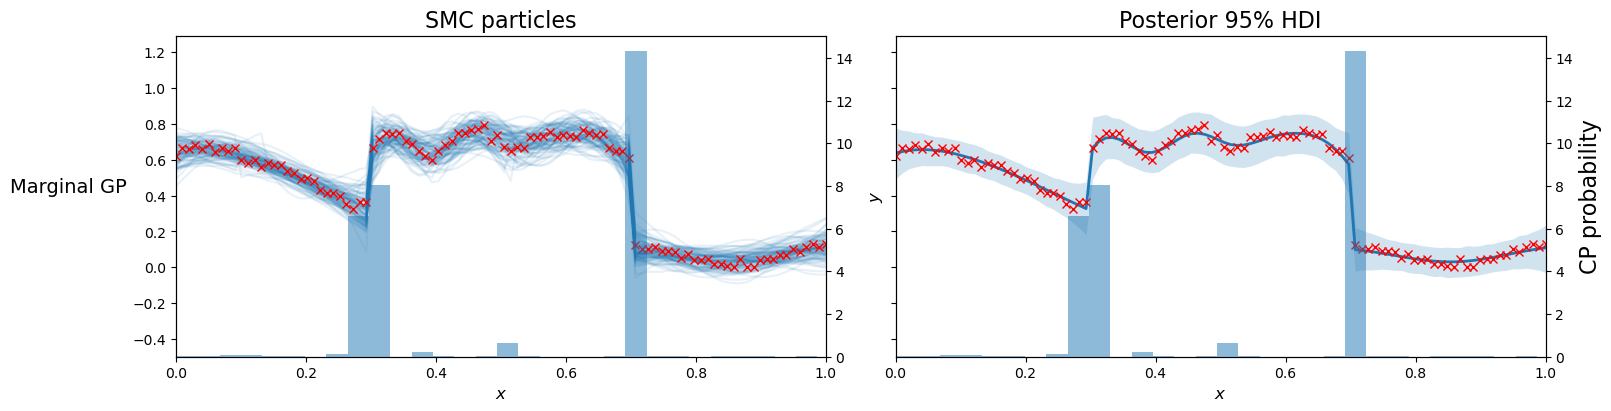

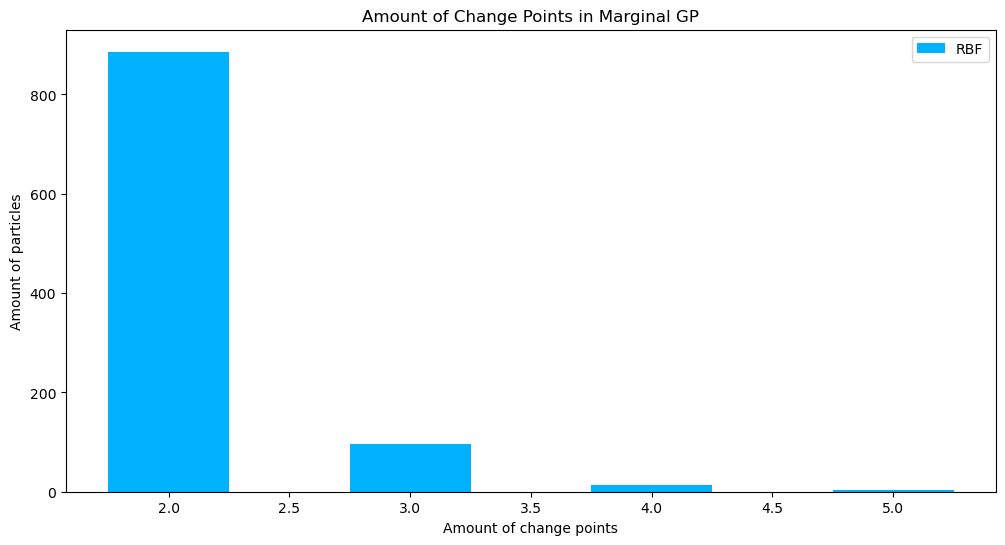

In [14]:
key = jrnd.PRNGKey(1234)
GP_marginal[1].plot_fit(key)
GP_marginal[1].plot_num()

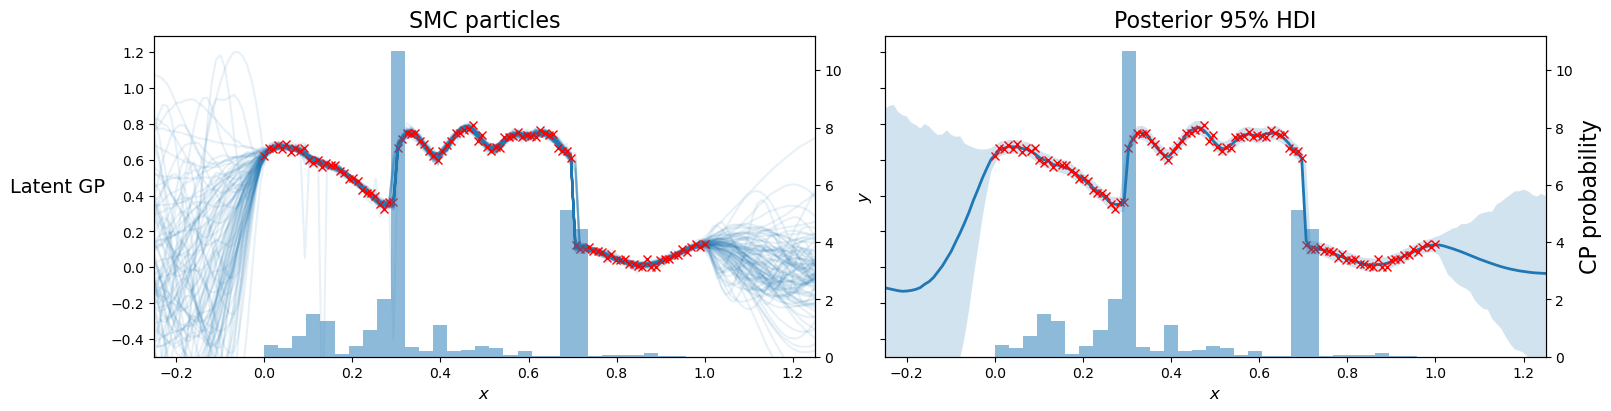

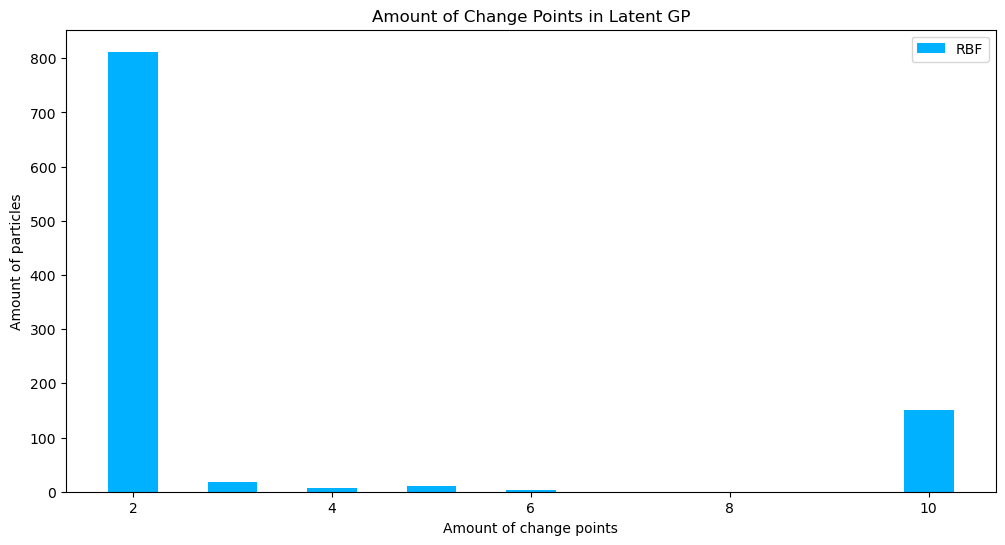

In [15]:
key = jrnd.PRNGKey(1234)
GP_latent[0].plot_fit(key)
GP_latent[0].plot_num()

### Merge different GP particles

In [8]:
'''Marginal'''

particles_list = [x.particles.particles for x in GP_marginal]
vals_flat, treedef = jax.tree_util.tree_flatten(particles_list[0])
new_particles = vals_flat
# print(new_particles[1].shape)
for i, particles in enumerate(particles_list):
    if i == 0:
        pass
    else:
        vals_flat, treedef = jax.tree_util.tree_flatten(particles)
        new_particles = [jnp.append(y, x, axis = 0) for x, y in zip(vals_flat, new_particles)]
# new_particles[1].shape

all_particles_marginal = jax.tree_util.tree_unflatten(treedef, new_particles)

'''Latent'''

particles_list = [x.particles.particles for x in GP_latent]
vals_flat, treedef = jax.tree_util.tree_flatten(particles_list[0])
new_particles = vals_flat
# print(new_particles[1].shape)
for i, particles in enumerate(particles_list):
    if i == 0:
        pass
    else:
        vals_flat, treedef = jax.tree_util.tree_flatten(particles)
        new_particles = [jnp.append(y, x, axis = 0) for x, y in zip(vals_flat, new_particles)]
# new_particles[1].shape

all_particles_latent = jax.tree_util.tree_unflatten(treedef, new_particles)

### Create new GP class instance with all particles 

In [9]:
import copy 
GP_marginal_all = copy.deepcopy(GP_marginal[0])
GP_marginal_all.particles = all_particles_marginal
GP_marginal_all.num_particles = num_runs * GP_marginal[0].num_particles

GP_latent_all = copy.deepcopy(GP_latent[0])
GP_latent_all.particles = all_particles_latent
GP_latent_all.num_particles = num_runs * GP_latent[0].num_particles

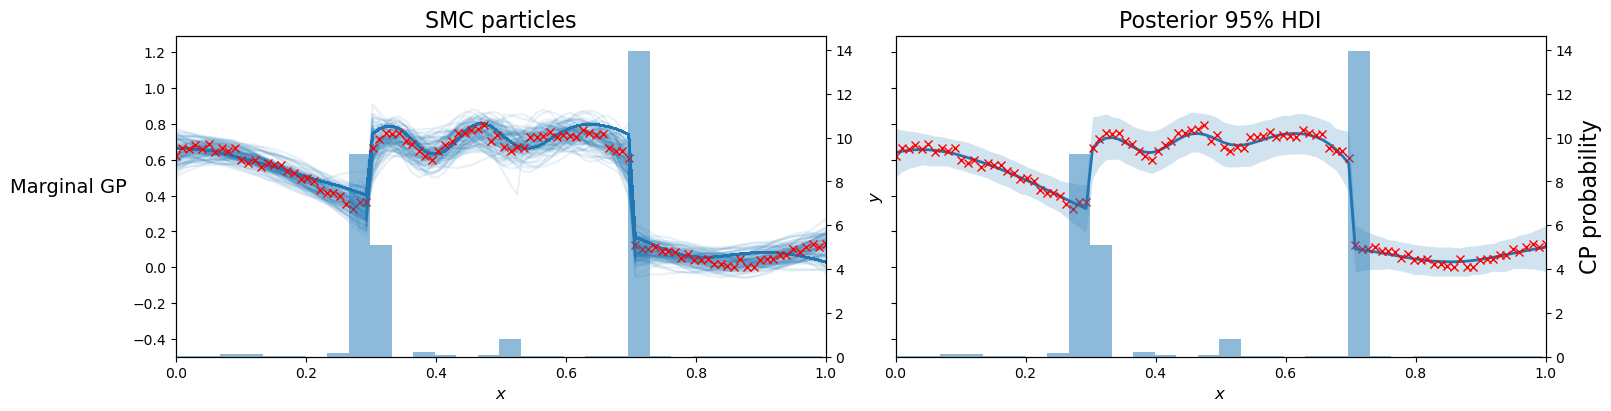

In [18]:
key = jrnd.PRNGKey(1234)
GP_marginal_all.plot_fit(key)

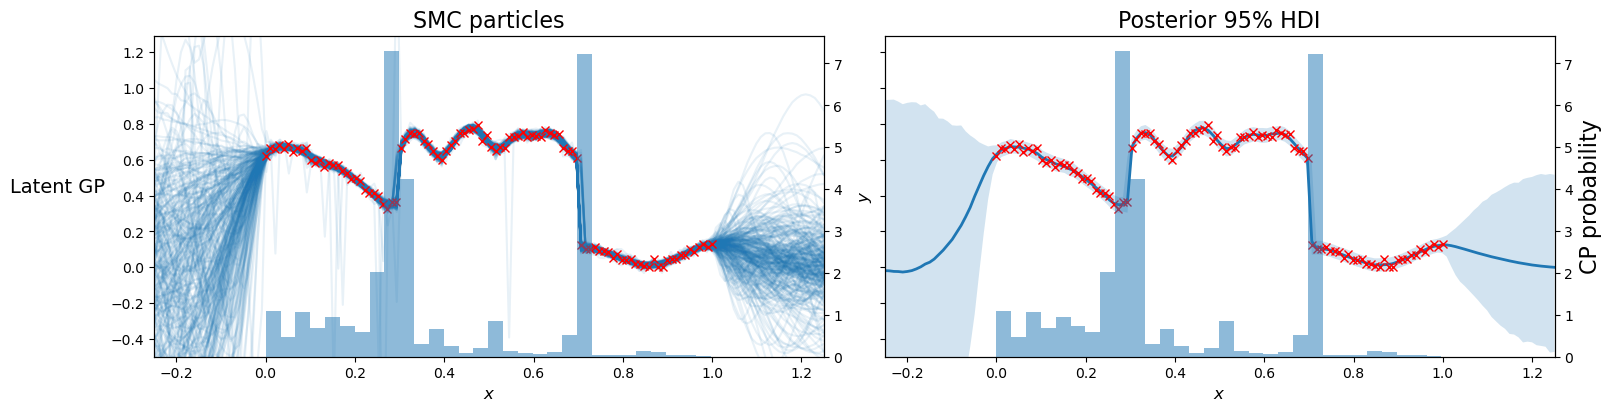

In [19]:
key = jrnd.PRNGKey(1234)
GP_latent_all.plot_fit(key, particles = all_particles_latent)

## Load IHMM

In [58]:
name = 'Toy_dataset_RBF_3'
num_runs = 3

IHMM = []
for i in range(num_runs):
    IHMM.append(jnp.load(name + f'/IHMM/ihmm_trained_{i}.npy', allow_pickle = True)[()])

In [59]:
test_ihmm = IHMM[0]
# test_ihmm.convergence['z']

# test_ihmm.get_params()

# test_ihmm.converged_params['A'].shape
# plt.plot(test_ihmm.converged_params['A'].squeeze())
# plt.plot(test_ihmm.converged_params['A'].squeeze()[:, 1])

Found 5 unique states
[0.9836 0.9805 0.9959 0.9936 0.9356]


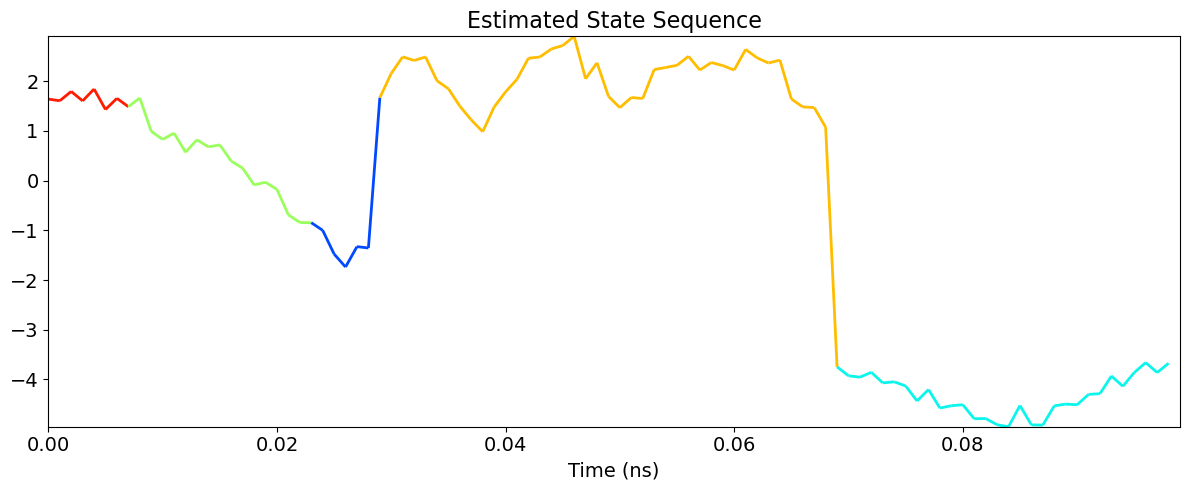

80.66409620090727
Found 5 unique states
[0.9818 0.9948 0.8993 0.9414 0.9998]


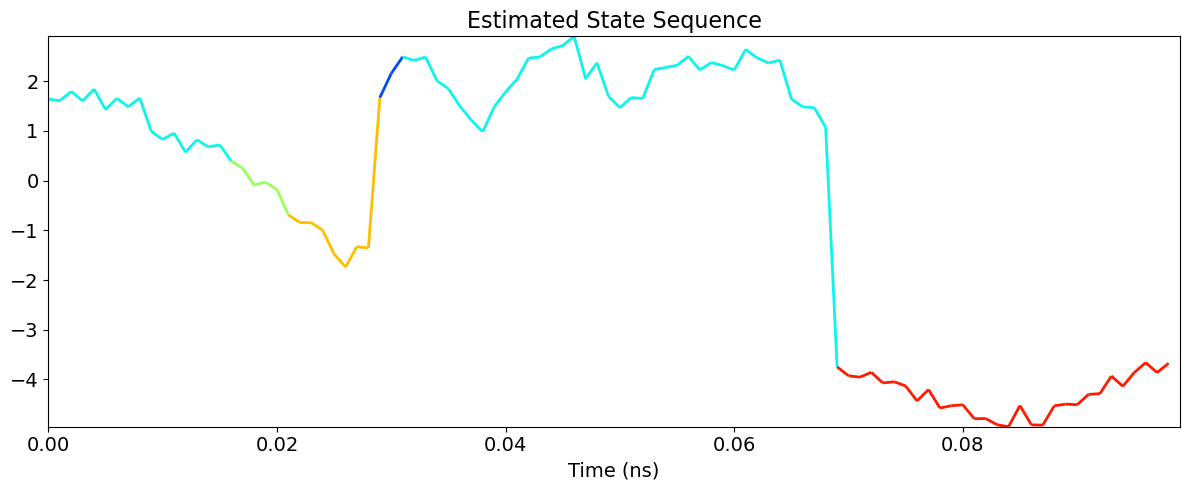

82.59014531109864
Found 3 unique states
[0.9899 0.9981 0.9978]


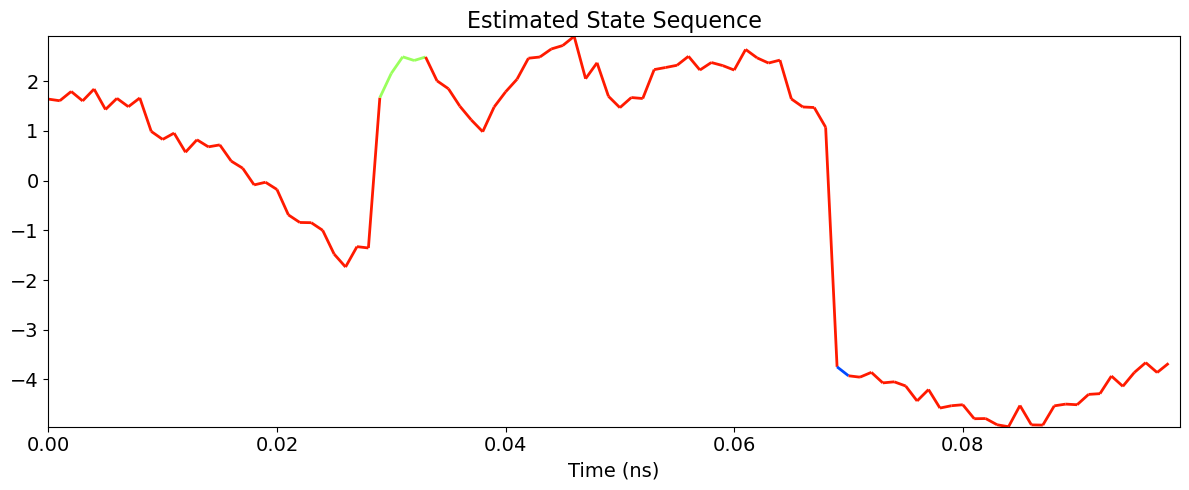

79.69049236424237


In [22]:
likelihood = [x.get_likelihood(0).squeeze() for x in IHMM]
# test_ihmm = IHMM[2]
# states = test_ihmm.z.squeeze()
# print(likelihood[0].shape)
# print(states[0])
for j in range(num_runs):
    sum_likelihood = 0
    states = IHMM[j].z.squeeze()
    IHMM[j].summarize_results()
    for i in range(likelihood[j].shape[-1]):
        sum_likelihood += likelihood[j][states[i], i]

    print(sum_likelihood)



## Merge different IHMMs?

## Trying master plot

(6534,)


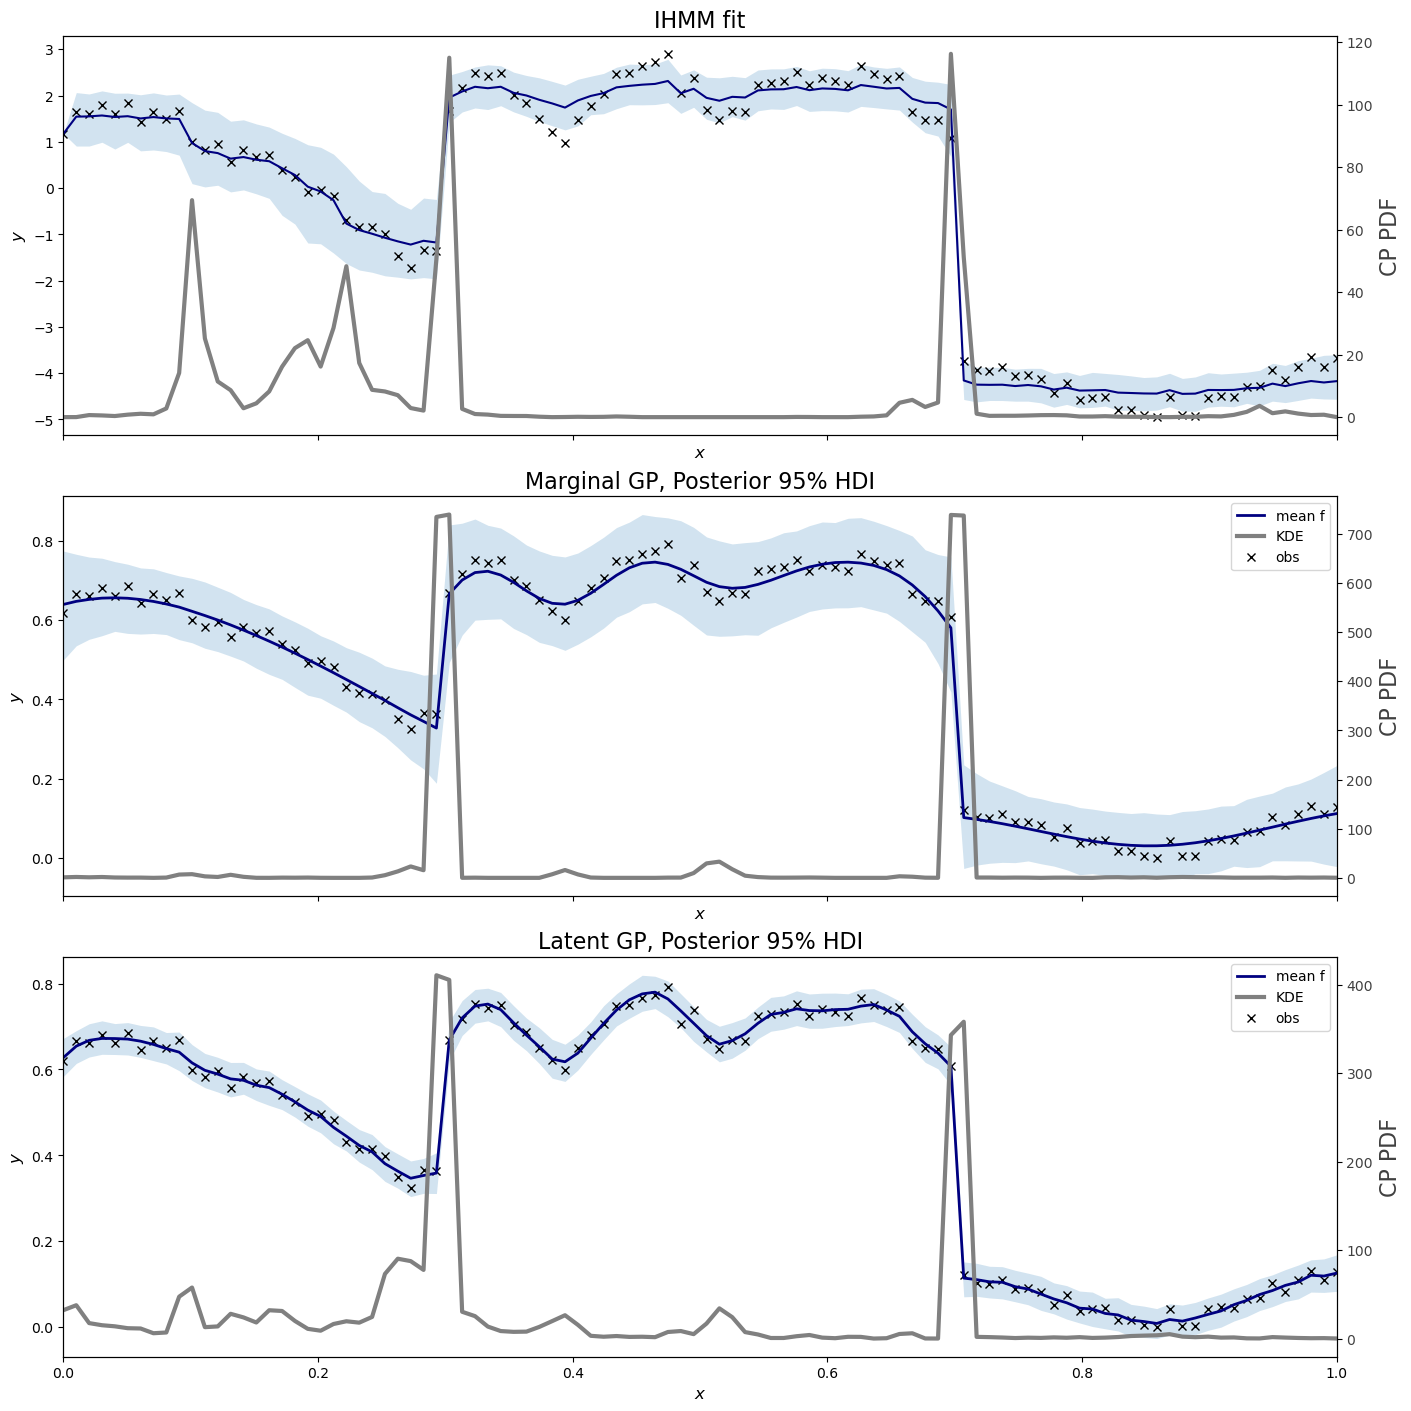

In [129]:
key = jrnd.PRNGKey(1245)
master_plot(key, IHMM, GP_marginal_all, GP_latent_all)